Trained with the dataset balanced across all classes.

Import all Needed Libraries and Modules.

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import keras
import keras_tuner
import tensorflow  as tf

import itertools
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add

Load the Dataset

In [2]:
try:
    for dirname, _, filenames in os.walk('ECG/inputs/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
except Exception as e:
    print(f"An error occurred: {e}")

ECG/inputs/dataECG\mitbih_test.csv
ECG/inputs/dataECG\mitbih_train.csv
ECG/inputs/dataECG\ptbdb_abnormal.csv
ECG/inputs/dataECG\ptbdb_normal.csv


In [3]:
train_data = pd.read_csv('ECG/inputs/dataECG/mitbih_train.csv', header = None)
test_data = pd.read_csv('ECG/inputs/dataECG/mitbih_test.csv', header = None)


#split target and value
train_target = train_data[187]
test_target  = test_data [187]
train = train_data.drop(187,axis = 1)
test = test_data.drop(187,axis = 1)

In [4]:
train_data.shape

(87554, 188)

In [5]:
train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
test_data.shape

(21892, 188)

Let's Explore the Dataset to see how it looks like.

In [7]:
expl_mitbih_train = train_target.copy()

In [8]:
expl_mitbih_test = test_target.copy()

In [9]:
expl_mitbih_train

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87549    4.0
87550    4.0
87551    4.0
87552    4.0
87553    4.0
Name: 187, Length: 87554, dtype: float64

In [10]:
expl_train = expl_mitbih_train.astype(int)

explor_train = expl_train.value_counts()

In [11]:
explor_train

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64

Let's see the data representation using Pie chart.

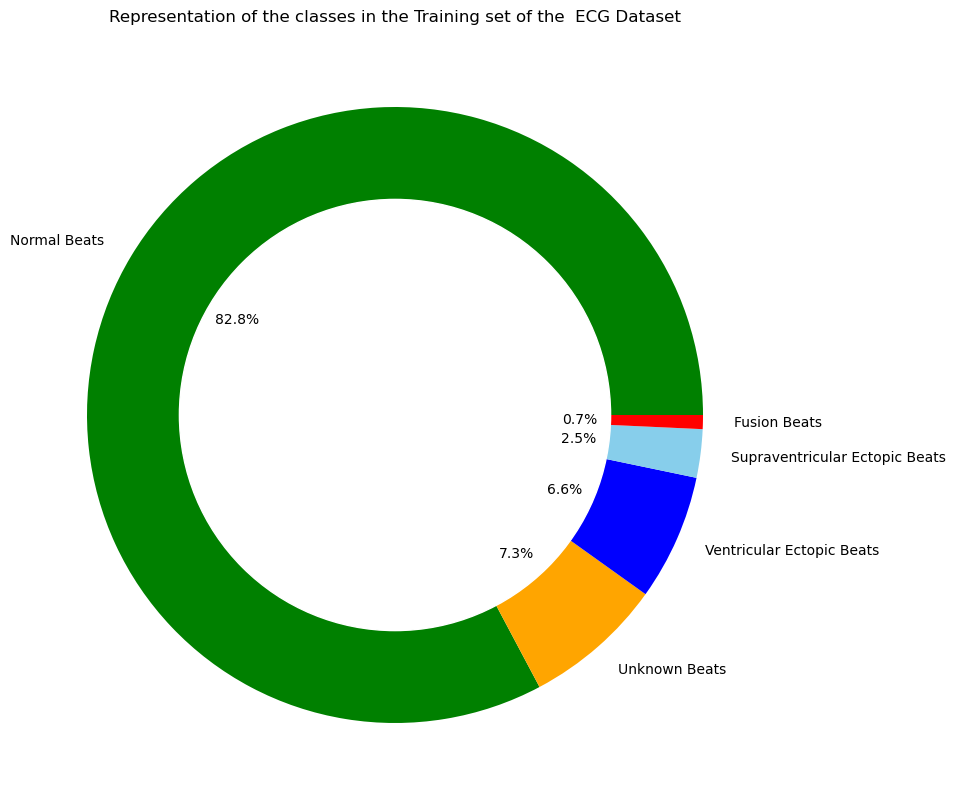

In [12]:
plt.figure(figsize = (10, 10))
circle = plt.Circle((0, 0), 0.7, color = "white")
plt.pie(explor_train, labels = ["Normal Beats", "Unknown Beats", "Ventricular Ectopic Beats", "Supraventricular Ectopic Beats", "Fusion Beats"], colors = ["green", "orange", "blue", "skyblue", "red"], autopct = "%1.1f%%")
k = plt.gcf()
k.gca().add_artist(circle)
plt.title("Representation of the classes in the Training set of the  ECG Dataset")
plt.show()

`Balancing the dataset.`

The training set is resampled such that each classes represented are in equal proportion.

In [13]:
data_sample1 = train_data[train_data[187] == 1]
data_sample2 = train_data[train_data[187] == 2]
data_sample3 = train_data[train_data[187] == 3]
data_sample4 = train_data[train_data[187] == 4]
data_sample0 = train_data[train_data[187] == 0]

Split the normal heart beat into 2 sets for train and validation set, which will be sampled later to equal size as other classes.

In [14]:
train_sample0, val_sample0 = train_test_split(data_sample0, test_size = 2/8, random_state = 42)

In [15]:
data_sample0 = (train_sample0).sample(n = 15000, random_state = 100)
validation_sample0 = (val_sample0).sample(n = 5000, random_state = 110)

In [16]:
data1_upsample = resample(data_sample1, replace = True, n_samples = 20000, random_state = 120)
data2_upsample = resample(data_sample2, replace = True, n_samples = 20000, random_state = 140)
data3_upsample = resample(data_sample3, replace = True, n_samples = 20000, random_state = 160)
data4_upsample = resample(data_sample4, replace = True, n_samples = 20000, random_state = 120)

In [17]:
train_sample1, val_sample1 = train_test_split(data1_upsample, test_size = 2/8, random_state = 42)
train_sample2, val_sample2 = train_test_split(data2_upsample, test_size = 2/8, random_state = 42)
train_sample3, val_sample3 = train_test_split(data3_upsample, test_size = 2/8, random_state = 42)
train_sample4, val_sample4 = train_test_split(data4_upsample, test_size = 2/8, random_state = 42)

`Concatenate all train samples and validation sample`

In [18]:
train_sampled = pd.concat([data_sample0, train_sample1, train_sample2, train_sample3, train_sample4])

In [19]:
balanced_dataset = train_sampled[187].value_counts()
print(balanced_dataset)

187
0.0    15000
1.0    15000
2.0    15000
3.0    15000
4.0    15000
Name: count, dtype: int64


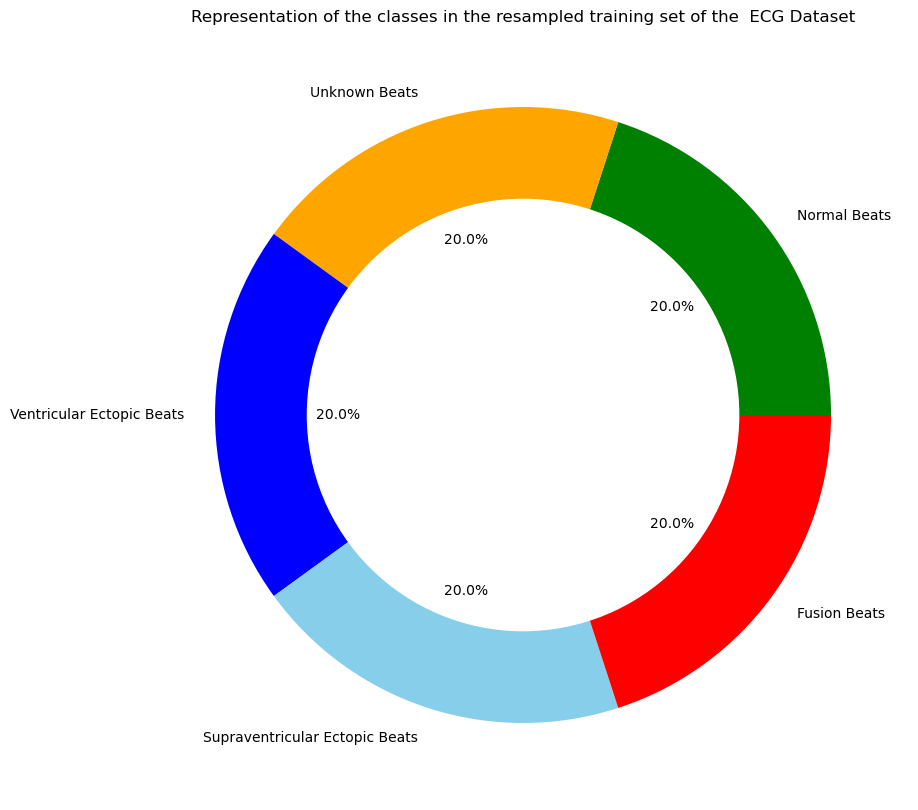

In [20]:
plt.figure(figsize = (10, 10))
circle = plt.Circle((0, 0), 0.7, color = "white")
plt.pie(balanced_dataset, labels = ["Normal Beats", "Unknown Beats", "Ventricular Ectopic Beats", "Supraventricular Ectopic Beats", "Fusion Beats"], colors = ["green", "orange", "blue", "skyblue", "red"], autopct = "%1.1f%%")
k = plt.gcf()
k.gca().add_artist(circle)
plt.title("Representation of the classes in the resampled training set of the  ECG Dataset")
plt.show()

`Concatenate all the validation sets to form one dataframe.`

In [21]:
val_sampled = pd.concat([validation_sample0, val_sample1, val_sample2, val_sample3, val_sample4])

In [22]:
balanced_val_dataset = val_sampled[187].value_counts()
print(balanced_val_dataset)

187
0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: count, dtype: int64


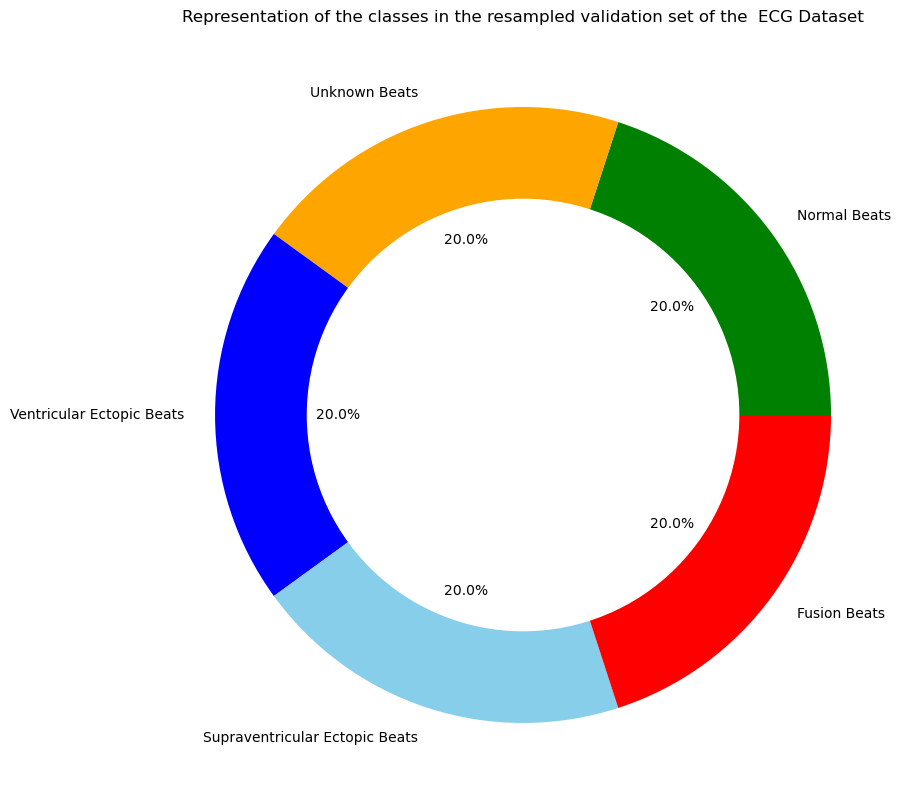

In [23]:
plt.figure(figsize = (10, 10))
circle = plt.Circle((0, 0), 0.7, color = "white")
plt.pie(balanced_val_dataset, labels = ["Normal Beats", "Unknown Beats", "Ventricular Ectopic Beats", "Supraventricular Ectopic Beats", "Fusion Beats"], colors = ["green", "orange", "blue", "skyblue", "red"], autopct = "%1.1f%%")
k = plt.gcf()
k.gca().add_artist(circle)
plt.title("Representation of the classes in the resampled validation set of the  ECG Dataset")
plt.show()

Let's take a look at what each heart beat represented in the data look like.

In [24]:
classes = train_sampled.groupby(187, group_keys = False).apply(lambda train_data : train_data.sample(1))

In [25]:
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
982,0.844974,0.729131,0.487223,0.201022,0.006814,0.005111,0.039182,0.052811,0.061329,0.063032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74675,1.000000,0.864286,0.242857,0.095238,0.235714,0.311905,0.328571,0.354762,0.352381,0.357143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74909,1.000000,0.924925,0.657658,0.271772,0.165165,0.145646,0.160661,0.138138,0.129129,0.109610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80672,1.000000,0.847887,0.549296,0.230986,0.077465,0.085915,0.078873,0.050704,0.043662,0.032394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
84951,0.856667,0.576667,0.550000,0.533333,0.530000,0.520000,0.483333,0.436667,0.393333,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


Text(0.5, 1.0, 'Normal Heart Beat')

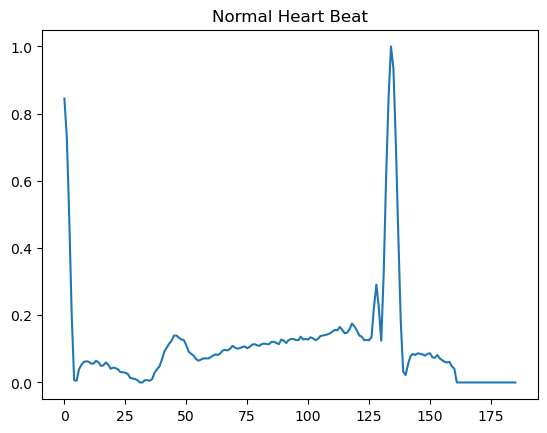

In [26]:
plt.plot(classes.iloc[0, : 186])
plt.title("Normal Heart Beat")

Text(0.5, 1.0, 'Supraventricular Ectopic Beat')

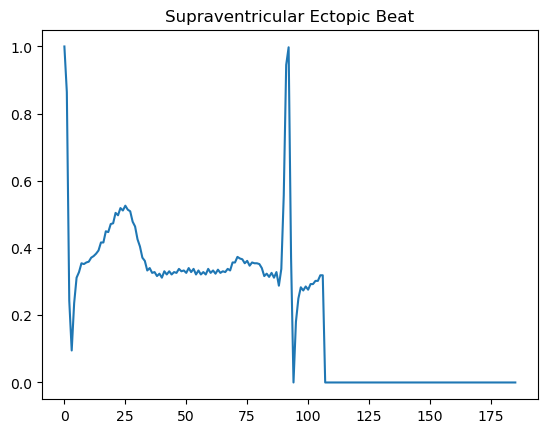

In [27]:
plt.plot(classes.iloc[1, : 186])
plt.title("Supraventricular Ectopic Beat")

Text(0.5, 1.0, 'Ventricular Ectopic Beat')

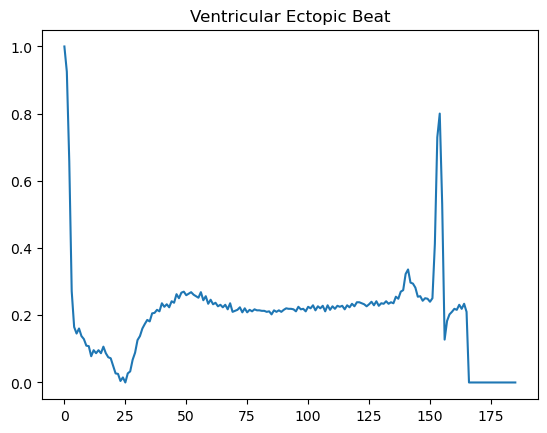

In [28]:
plt.plot(classes.iloc[2, : 186])
plt.title("Ventricular Ectopic Beat")

Text(0.5, 1.0, 'Fusion Beat')

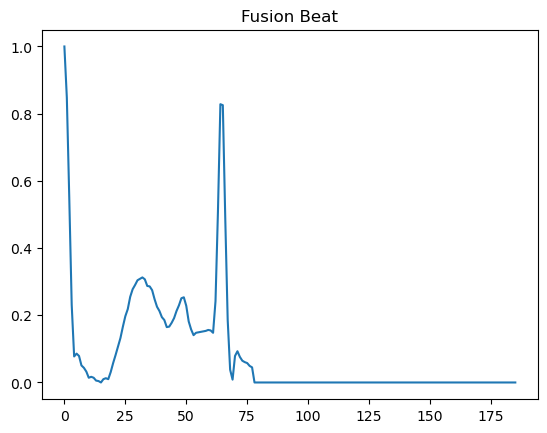

In [29]:
plt.plot(classes.iloc[3, : 186])
plt.title("Fusion Beat")

Text(0.5, 1.0, 'Unknown Beat')

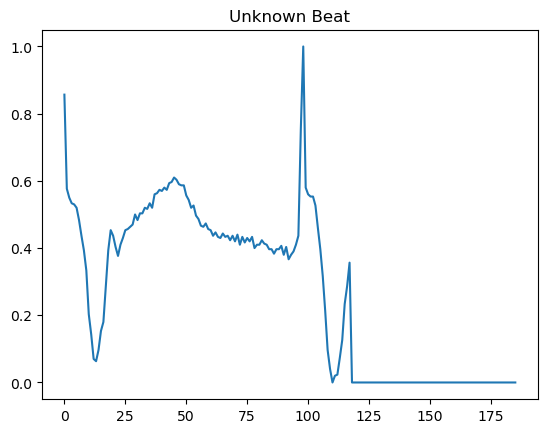

In [30]:
plt.plot(classes.iloc[4, : 186])
plt.title("Unknown Beat")

Noise will not be added to the training set.

Data Preparation.

In [31]:
train_target = train_sampled[187]

test_target = test_data[187]
val_target = val_sampled[187]

In [32]:
y_train_sampled = to_categorical(train_target)
y_test = to_categorical(test_target)
y_val = to_categorical(val_target)


In [33]:
x_train_sampled = train_sampled.iloc[ : ,  : 186].values
x_test = test_data.iloc[ : ,  : 186].values
x_val_sampled = val_sampled.iloc[ : ,  : 186].values

In [34]:

x_test = x_test.reshape(len(x_test), x_test.shape[1], 1)
x_train_sampled = x_train_sampled.reshape(len(x_train_sampled), x_train_sampled.shape[1], 1)
x_val_sampled = x_val_sampled.reshape(len(x_val_sampled), x_val_sampled.shape[1], 1)

In [35]:
y_train_sampled

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [36]:
y_train_sampled.shape

(75000, 5)

In [37]:
x_train_sampled

array([[[1.        ],
        [0.85074627],
        [0.23880596],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.52941179],
        [0.21218488],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.77503854],
        [0.45762712],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.71080667],
        [0.60273975],
        [0.5022831 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.70028818],
        [0.5129683 ],
        [0.47262248],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.94050342],
        [0.88215101],
        [0.81235701],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [38]:
x_train_sampled.shape

(75000, 186, 1)

In [39]:
x_val_sampled.shape

(25000, 186, 1)

`An adaptation of residual connection inspired fron ResNet with basic CNN.`

In [40]:
def residual_block(x, filters, kernel_size = 3, strides = 1):
    # Shortcut connection
    shortcut = x
    
    # First convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = HeNormal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = HeNormal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Adjusting the shortcut connection with a 1x1 convolution
    shortcut = Conv1D(filters, kernel_size = 1, strides = strides, padding = "same")(shortcut)
    
    # Adding the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    
    return x

In [41]:
input_shape = (x_train_sampled.shape)
class_num = len(classes)

In [42]:
class_num

5

In [43]:
input_shape

(75000, 186, 1)

In [44]:
input_shape = (x_train_sampled.shape[1], 1)
input_shape = tf.keras.Input(shape = input_shape)

`Using RMSProp Optimizer`

In [45]:
def build_model(hp):

    input_shape = (x_train_sampled.shape[1], 1)
    class_num = len(classes)
    model = tf.keras.Sequential()
    # Input layer
    input_layer = tf.keras.layers.Input(shape = input_shape)

    # Convolutional layers
    x = tf.keras.layers.Conv1D(
        filters = 64,
        kernel_size = 6,
        strides = 2,
        padding="same",
        kernel_initializer = tf.keras.initializers.HeNormal()
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("selu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size = 3, padding = "same")(x)

    # Residual blocks
    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 64)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 128)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    x = residual_block(x, filters = 256)
    x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)

    # Flatten layer
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    for i in range(hp.Int("num_dense_layers", 1, 3)):
        x = tf.keras.layers.Dense(
            units = hp.Int(f"units_dense_{i}", min_value=32, max_value = 512, step = 32),
            activation = hp.Choice("activation_dense", ["relu", "selu"])
        )(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)
    
    for i in range(hp.Int("num_dense_layers", 1, 3)):
        x = tf.keras.layers.Dense(
            units = hp.Int(f"units_dense_{i}", min_value=32, max_value = 512, step = 32),
            activation = hp.Choice("activation_dense", ["relu", "selu"])
        )(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    # Output layer
    model_output = tf.keras.layers.Dense(class_num, activation = "softmax")(x)

    # Compile the model
    model = tf.keras.Model(inputs = input_layer, outputs = model_output)
    learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 2e-2, sampling = "log")
    model.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate, rho = 0.9),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model


In [46]:
build_model(keras_tuner.HyperParameters())

In [47]:
input_shape = (x_train_sampled.shape[1], 1)

In [48]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 5,
    executions_per_trial = 2,
    overwrite = True,
    directory = "./",
    project_name = "mitbih2d_tuned",
)

In [49]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_residual_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
Dropout_Residual_Blocks (Boolean)
{'default': False, 'conditions': []}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.02, 'step': None, 'sampling': 'log'}


In [50]:
tuner.search(
    x_train_sampled, y_train_sampled, 
    epochs = 3, 
    validation_data = (x_val_sampled, y_val),
    callbacks = [keras.callbacks.TensorBoard("./tbb2b_logs")]
    )

Trial 5 Complete [00h 09m 35s]
val_accuracy: 0.20000000298023224

Best val_accuracy So Far: 0.967739999294281
Total elapsed time: 00h 55m 32s


In [51]:
models = tuner.get_best_models(num_models = 2)
best_model = models[0]

In [52]:
tuner.results_summary()

Results summary
Results in ./mitbih2d_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
num_residual_blocks: 2
Dropout_Residual_Blocks: False
num_dense_layers: 1
units_dense_0: 480
activation_dense: relu
learning_rate: 0.0011594590738768533
units_dense_1: 448
units_dense_2: 320
Score: 0.967739999294281

Trial 2 summary
Hyperparameters:
num_residual_blocks: 4
Dropout_Residual_Blocks: False
num_dense_layers: 2
units_dense_0: 224
activation_dense: relu
learning_rate: 0.00014272260118053262
units_dense_1: 96
units_dense_2: 32
Score: 0.9661800265312195

Trial 1 summary
Hyperparameters:
num_residual_blocks: 5
Dropout_Residual_Blocks: True
num_dense_layers: 3
units_dense_0: 64
activation_dense: selu
learning_rate: 0.0003633285077127645
units_dense_1: 256
units_dense_2: 224
Score: 0.8896200060844421

Trial 0 summary
Hyperparameters:
num_residual_blocks: 3
Dropout_Residual_Blocks: True
num_dense_layers: 3
units_dense_0: 64
activation_

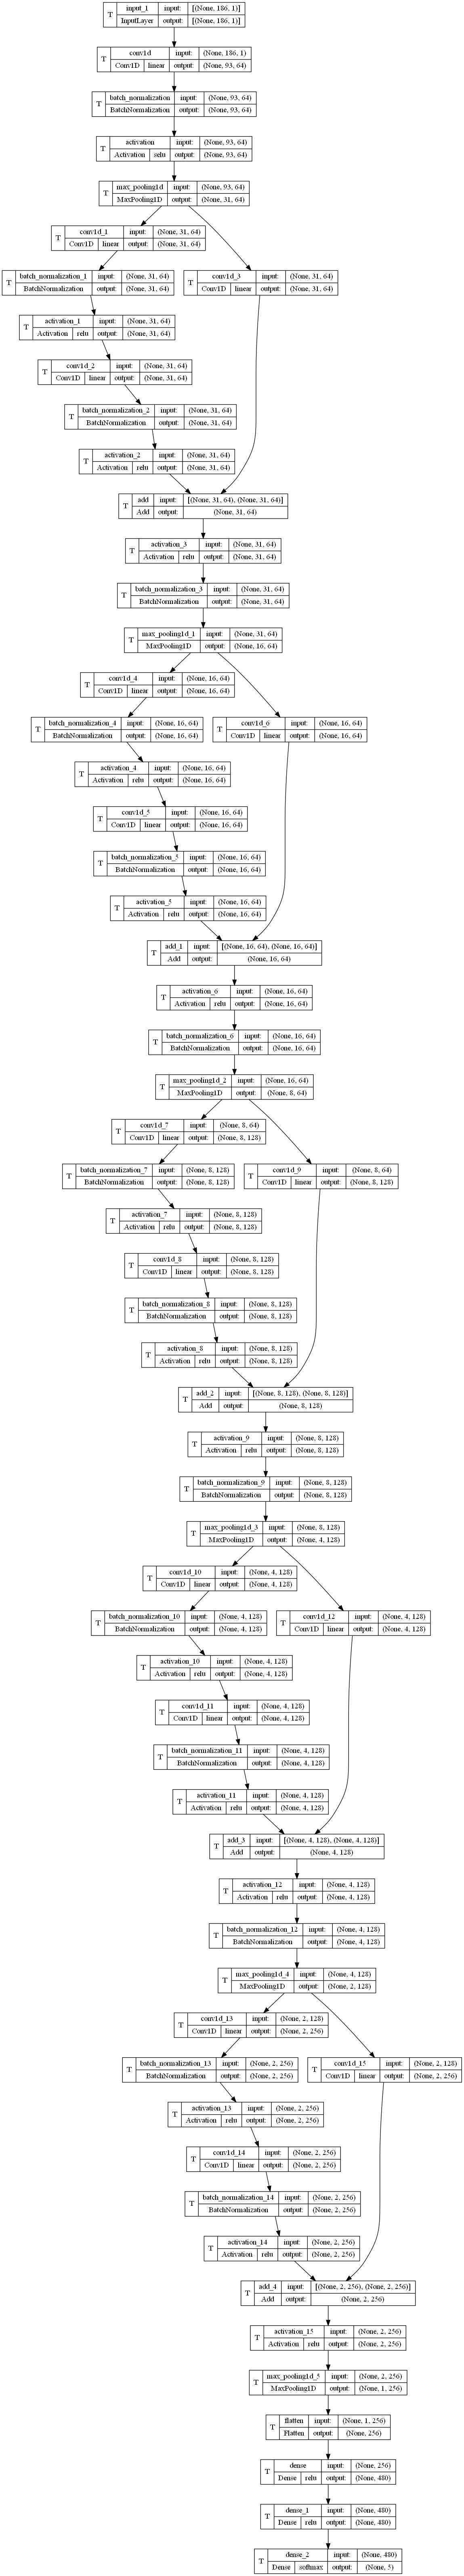

In [53]:
tf.keras.utils.plot_model(best_model,
                          to_file='modelv2b.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

In [54]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 186, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 93, 64)               448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 93, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 93, 64)               0         ['batch_normalization[0][0

In [55]:
history = best_model.fit(
    x_train_sampled, y_train_sampled, 
    epochs = 10, 
    validation_data = (x_val_sampled, y_val),
    batch_size = 32,
    callbacks = [keras.callbacks.TensorBoard("./tbb2b_logs")]
    )

Epoch 1/10
2344/2344 [==============================] - 91s 34ms/step - loss: 0.1030 - accuracy: 0.9698 - val_loss: 0.1008 - val_accuracy: 0.9721
Epoch 2/10
2344/2344 [==============================] - 80s 34ms/step - loss: 0.0917 - accuracy: 0.9744 - val_loss: 0.0718 - val_accuracy: 0.9779
Epoch 3/10
2344/2344 [==============================] - 82s 35ms/step - loss: 0.0848 - accuracy: 0.9771 - val_loss: 0.0817 - val_accuracy: 0.9809
Epoch 4/10
2344/2344 [==============================] - 82s 35ms/step - loss: 0.0779 - accuracy: 0.9797 - val_loss: 0.1121 - val_accuracy: 0.9717
Epoch 5/10
2344/2344 [==============================] - 80s 34ms/step - loss: 0.0735 - accuracy: 0.9815 - val_loss: 0.0855 - val_accuracy: 0.9810
Epoch 6/10
2344/2344 [==============================] - 80s 34ms/step - loss: 0.0656 - accuracy: 0.9835 - val_loss: 0.0697 - val_accuracy: 0.9844
Epoch 7/10
2344/2344 [==============================] - 80s 34ms/step - loss: 0.0628 - accuracy: 0.9846 - val_loss: 0.0791 -

Model Performance Plots.

In [56]:
def model_plots(history):
    """ This function plots the model accuracy and loss. """
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()


    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()

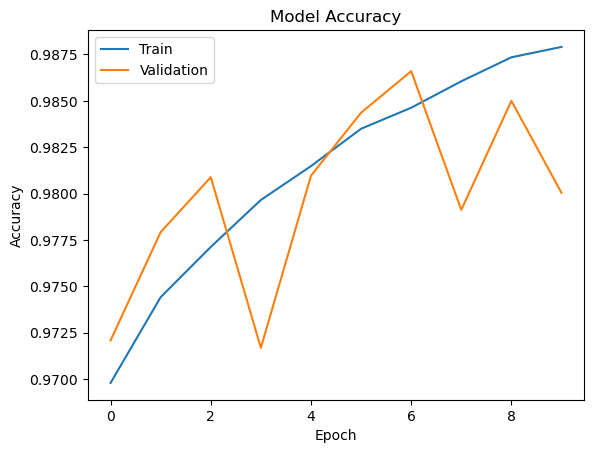

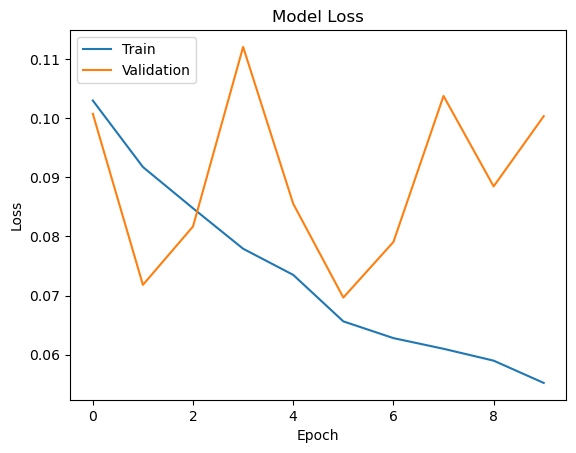

In [57]:
model_plots(history = history)

Model Evaluation

In [58]:
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy is: {accuracy} and Test Loss is: {loss}")

685/685 [==============================] - 7s 9ms/step - loss: 0.2971 - accuracy: 0.9720
Test Accuracy is: 0.9719532132148743 and Test Loss is: 0.2971474528312683


In [59]:
y_pred = best_model.predict(x_test)

685/685 [==============================] - 7s 9ms/step


Plot Confussion Matrix.

In [60]:

def plot_confusion_matrix (model, x_test, y_test, class_names):
    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_classes)

    plt.figure(figsize = (10, 10))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = class_names, yticklabels = class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))

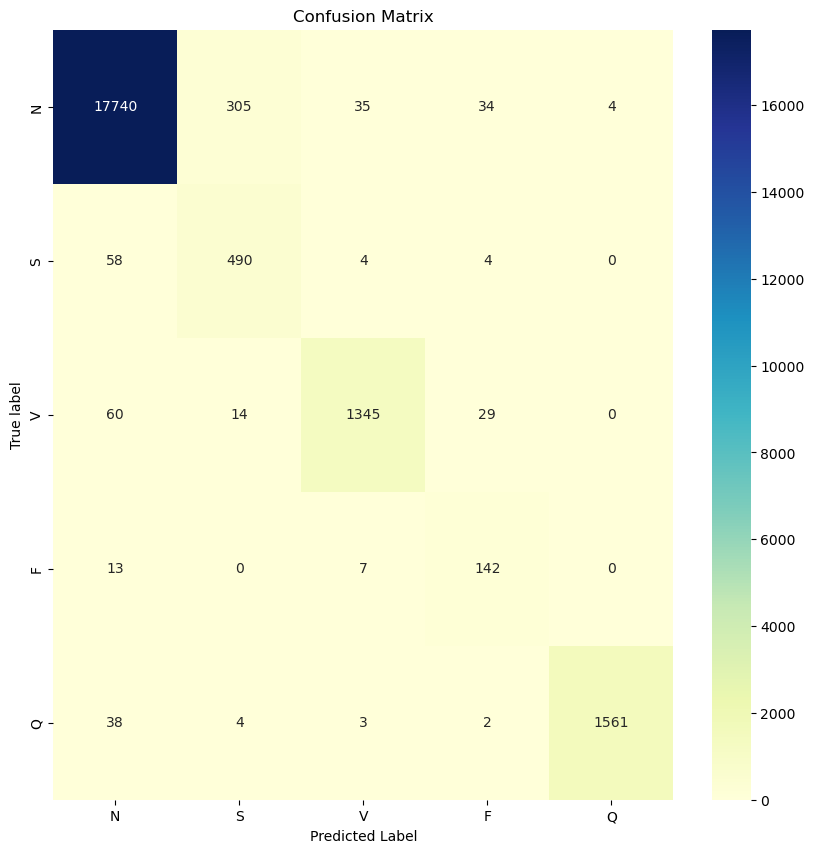

              precision    recall  f1-score   support

           N       0.99      0.98      0.98     18118
           S       0.60      0.88      0.72       556
           V       0.96      0.93      0.95      1448
           F       0.67      0.88      0.76       162
           Q       1.00      0.97      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.85      0.93      0.88     21892
weighted avg       0.98      0.97      0.97     21892



In [61]:
class_names = ["N", "S", "V", "F", "Q"]

plot_confusion_matrix(best_model, x_test, y_test, class_names)

In [62]:
def plot_confusion_matrix(classes,
                          normalize = False,
                          title = "Confusion matrix",
                          cmap = plt.cm.Blues):
    
    """

    This function plots and prints the confusion matrix.
    Normalization can be applied by setting "normalize = True".

    """

    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
    np.set_printoptions(precision = 2)
    
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    
    
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))


Normalized confusion matrix


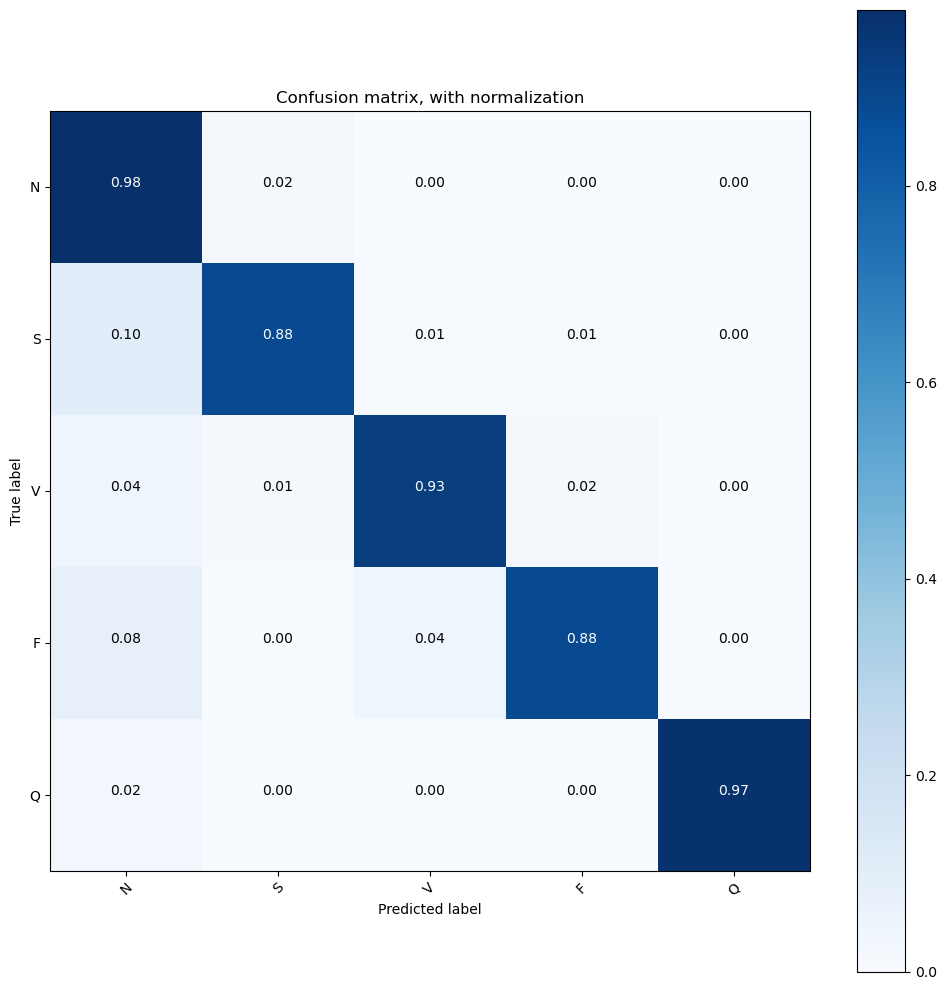

              precision    recall  f1-score   support

           N       0.99      0.98      0.98     18118
           S       0.60      0.88      0.72       556
           V       0.96      0.93      0.95      1448
           F       0.67      0.88      0.76       162
           Q       1.00      0.97      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.85      0.93      0.88     21892
weighted avg       0.98      0.97      0.97     21892



In [63]:
plot_confusion_matrix(classes = class_names, normalize = True,
                      title = "Confusion matrix, with normalization")


Save the Model.

In [64]:
model_dir = "trained_models"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
best_model.save(os.path.join(model_dir, "projectv02bModel.h5"))

c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
# To load the model in future;

#loaded_model = tf.keras.models.load_model(os.path.join(model_dir, "projectv02bModel.h5"))